# Data Mining Work 1

## 1. Author Info
* sid: 5140369016
* name: 邢俊劼
* email: gavinxing9016@gmail.com

## 2. Data Set

* HTRU2 Data Set
* <http://archive.ics.uci.edu/ml/datasets/HTRU2>

## 2.1 Information
> HTRU2 is a data set which describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey (South) . 

> Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter .

> As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars 
rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes. 

> Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation . Thus a potential signal detection known as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. However in practice almost all detections are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find. 

> Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. Classification systems in particular are being widely adopted, 
which treat the candidate data sets as binary classification problems. Here the legitimate pulsar examples are a minority positive class, and spurious examples the majority negative class. At present multi-class labels are unavailable, given the costs associated with data annotation. 

> The data set shared here contains 16,259 spurious examples caused by RFI/noise, and 1,639 real pulsar examples. These examples have all been checked by human annotators. 

> The data is presented in two formats: CSV and ARFF (used by the WEKA data mining tool). Candidates are stored in both files in separate rows. Each row lists the variables first, and the class label is the final entry. The class labels used are 0 (negative) and 1 (positive). 

> Please note that the data contains no positional information or other astronomical details. It is simply feature data extracted from candidate files using the PulsarFeatureLab tool .

## 2.2 Attribute Info
> Each candidate is described by 8 continuous variables, and a single class variable. The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency . The remaining four variables are similarly obtained from the DM-SNR curve. These are summarised below: 

> 1. Mean of the integrated profile. 
> 2. Standard deviation of the integrated profile. 
> 3. Excess kurtosis of the integrated profile. 
> 4. Skewness of the integrated profile. 
> 5. Mean of the DM-SNR curve. 
> 6. Standard deviation of the DM-SNR curve. 
> 7. Excess kurtosis of the DM-SNR curve. 
> 8. Skewness of the DM-SNR curve. 
> 9. Class 

> 17,898 total examples. 
> 1,639 positive examples. 
> 16,259 negative examples.



## 3. Load data

In [119]:
import pandas as pd
import numpy as np
from time import time
import os
mode = 'full'  # set mode to 'debug' to use 1000 samples

In [120]:
data_path = './data/HTRU_2.csv'
data = pd.read_csv(data_path, header=None) # no head in .csv
data.columns = ["M1", "SD1", "EK1", "S1", "M2", "SD2", "EK2", "S2", "Y"]
data.head()

,M1,SD1,EK1,S1,M2,SD2,EK2,S2,Y
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [121]:
cols = list(data.columns) # split data to X and Y
X = data[cols[0:8]] 
Y = data['Y']

## 4. Data Explore

### 4.1 Data Correlation
> 在概率论和统计学中，相关（Correlation，或称相关系数或关联系数），显示两个随机变量之间线性关系的强度和方向。在统计学中，相关的意义是用来衡量两个变量相对于其相互独立的距离。在这个广义的定义下，有许多根据数据特点而定义的用来衡量数据相关的系数。<https://zh.wikipedia.org/wiki/%E7%9B%B8%E5%85%B3>

In [122]:
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 240 , 15 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

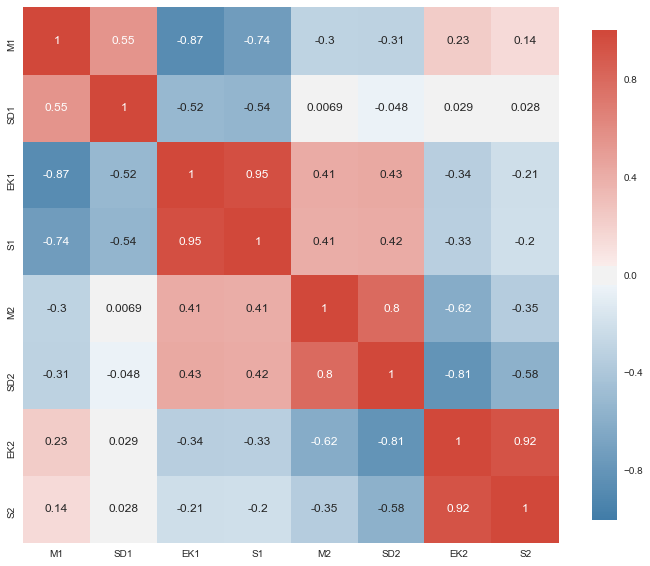

In [123]:
plot_correlation_map(X)

### 4.2  Principle Component Analysys
>在多元统计分析中，主成分分析（英语：Principal components analysis，PCA）是一种分析、简化数据集的技术。主成分分析经常用于减少数据集的维数，同时保持数据集中的对方差贡献最大的特征。这是通过保留低阶主成分，忽略高阶主成分做到的。这样低阶成分往往能够保留住数据的最重要方面。但是，这也不是一定的，要视具体应用而定。由于主成分分析依赖所给数据，所以数据的准确性对分析结果影响很大。
<https://zh.wikipedia.org/wiki/%E4%B8%BB%E6%88%90%E5%88%86%E5%88%86%E6%9E%90>

    分析结果可以发现，前两个变量的重要性比较大；因此我在之后尝试使用t-sne算法将数据集的属性降低到2维来进行处理

In [124]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(X)
print(pca.explained_variance_)

[ 11634.42743269   1044.40928441    549.7129762      82.27319191
     32.55276879     12.80348195      0.52167545      0.03739468]


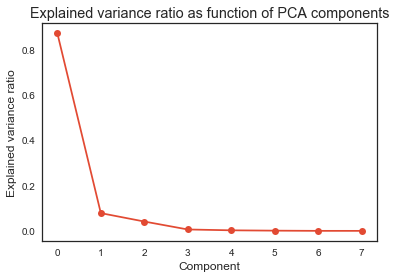

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(list(pca.explained_variance_ratio_),'-o')
plt.title('Explained variance ratio as function of PCA components')
plt.ylabel('Explained variance ratio')
plt.xlabel('Component')
plt.show()

## 5. Data sampling
### 根据数据统计，共有1639个正类和16259个负类，数据集过于不平衡，因此我做了一下数据采样，将比例调整为1:1

In [126]:
# some data process
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection

# do Standardlization
X = StandardScaler().fit_transform(X)
Y = np.array(Y)

index_not = []
index_is = []
print(X.shape, Y.shape)
for index, x in enumerate(X):
    if Y[index] == 0:
        index_not.append(index)
    else:
        index_is.append(index)
print("total {} rows are detected as pulsar while {} rows aren't.".format(len(index_is), len(index_not)))

(17898, 8) (17898,)
total 1639 rows are detected as pulsar while 16259 rows aren't.


In [127]:
# 平衡数据集
import random
delete_not_index = random.sample(index_not, len(index_not) - len(index_is))
delete_not_index.sort(reverse=True)
for index in delete_not_index:
    X = np.delete(X, index, axis=0)
    Y = np.delete(Y, index, axis=0)


In [128]:
index_not = []
index_is = []
for index, x in enumerate(X):
    if Y[index] == 0:
        index_not.append(index)
    else:
        index_is.append(index)
print("total {} rows are detected as pulsar while {} rows aren't.".format(len(index_is), len(index_not)))
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.4, random_state=0)
print(X_train.shape, Y_train.shape)

total 1639 rows are detected as pulsar while 1639 rows aren't.
(1966, 8) (1966,)


## 6. Classification
### Main task of this homework

In [129]:
from KNN import KNN  # import my KNN
cell_start=time()
k = KNN(n_neighbors=3)
k.fit(X_train, Y_train)
pred_knn = k.predict(X_test)
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Time Elapsed:  0.3360128402709961


In [130]:
def score(pred_y, test_y):
    tp, fp, tn, fn = [0,0,0,0]
    for index, y in enumerate(pred_y):
        if y == test_y[index]:
            if y == 0:
                tn += 1
            else:
                tp += 1
        else:
            if y == 0:
                fn += 1
            else:
                fp += 1
    print("Accuracy: {}\nRecall: {}".format(tp/(tp+fp), tp/(tp+fn)))
    return tp/(tp+fp), tp/(tp+fn)
                

In [131]:
score(pred_knn, Y_test)

Accuracy: 0.9475357710651828
Recall: 0.916923076923077


(0.9475357710651828, 0.916923076923077)

## 7. Classification After PCA
### My extended task of this homework

In [132]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
newX = pca.fit_transform(X)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(newX, Y, test_size=0.4, random_state=0)
print(X_train.shape, Y_train.shape)

(1966, 2) (1966,)


In [133]:
from KNN import KNN  # import my KNN
cell_start=time()
k = KNN(n_neighbors=3)
k.fit(X_train, Y_train)
pred_knn = k.predict(X_test)
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Time Elapsed:  0.3077390193939209


In [134]:
score(pred_knn, Y_test)

Accuracy: 0.9093701996927803
Recall: 0.9107692307692308


(0.9093701996927803, 0.9107692307692308)

## 5. Classification
### Main task of this homework

### 5.1 SVM

In [9]:
from sklearn.svm import SVC
from sklearn import metrics

cell_start=time()
svc = SVC()
svm_model = svc.fit(X_train, Y_train)
print("Acurracy: ", svm_model.score(X_test,Y_test))
Y_pred_svm  = svm_model.predict(X_test)
print(metrics.classification_report(Y_pred_svm, Y_test))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.97905027933
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      6648
          1       0.80      0.93      0.86       512

avg / total       0.98      0.98      0.98      7160

Time Elapsed:  0.6914520263671875


### 5.2 Naive Bayes

In [10]:
from sklearn.naive_bayes import BernoulliNB

cell_start=time()
nb = BernoulliNB()
nb_model = nb.fit(X_train,Y_train)
print("Acurracy: ", nb_model.score(X_test,Y_test))
Y_pred_nb = nb_model.predict(X_test)
print(metrics.classification_report(Y_pred_nb, Y_test))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.949720670391
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      6368
          1       0.86      0.65      0.74       792

avg / total       0.95      0.95      0.95      7160

Time Elapsed:  0.018021106719970703


### 5.3 Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression as LR

cell_start=time()
lr = LR()
lr_model = lr.fit(X_train,Y_train)
print("Acurracy: ", lr_model.score(X_test,Y_test))
Y_pred_lr = lr_model.predict(X_test)
print(metrics.classification_report(Y_pred_lr, Y_test))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.979329608939
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      6646
          1       0.81      0.93      0.87       514

avg / total       0.98      0.98      0.98      7160

Time Elapsed:  0.049653053283691406


### 5.4 Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier

cell_start=time()
dt = DecisionTreeClassifier()
dt_model = dt.fit(X_train,Y_train)
print("Acurracy: ", dt_model.score(X_test,Y_test))
Y_pred_dt = dt_model.predict(X_test)
print(metrics.classification_report(Y_pred_dt, Y_test))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.967318435754
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      6538
          1       0.83      0.79      0.81       622

avg / total       0.97      0.97      0.97      7160

Time Elapsed:  0.14553213119506836


### 5.5 Ranfom Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

cell_start=time()
rf = RandomForestClassifier()
rf_model = rf.fit(X_train,Y_train)
print("Acurracy: ", rf_model.score(X_test,Y_test))
Y_pred_rf = rf_model.predict(X_test)
print(metrics.classification_report(Y_pred_rf, Y_test))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.978631284916
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      6635
          1       0.81      0.92      0.86       525

avg / total       0.98      0.98      0.98      7160

Time Elapsed:  0.20850586891174316


## 6. Dimension Reduction
### 6.1 using t-sne to reduce feature dimention to 2

In [14]:
from sklearn.manifold import TSNE

cell_start=time()
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
tsne_x = model.fit_transform(X)
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Time Elapsed:  831.8824689388275


In [15]:
X_train_tsne, X_test_tsne, Y_train_tsne, Y_test_tsne = model_selection.train_test_split(tsne_x, Y, test_size=0.4, random_state=0)
print(X_train_tsne.shape, Y_train_tsne.shape)

(10738, 2) (10738,)


## 6.2 Using the most 2 important attribute according to PCA

In [16]:
X_two = X[:,[0,1]]
X_train_two, X_test_two, Y_train_two, Y_test_two = model_selection.train_test_split(X_two, Y, test_size=0.4, random_state=0)

## 7. Classification after t-sne

### 7.1 SVM

In [17]:
cell_start=time()
svc = SVC()
svm_model_tsne = svc.fit(X_train_tsne, Y_train_tsne)
print ("Acurracy: ", svm_model_tsne.score(X_test_tsne,Y_test_tsne))
Y_pred_svm_tsne  = svm_model_tsne.predict(X_test_tsne)
print(metrics.classification_report(Y_pred_svm_tsne, Y_test_tsne))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.938966480447
             precision    recall  f1-score   support

          0       1.00      0.94      0.97      6981
          1       0.28      0.94      0.43       179

avg / total       0.98      0.94      0.95      7160

Time Elapsed:  3.686366081237793


### 7.2 Naive Bayes

In [18]:
cell_start=time()
nb = BernoulliNB()
nb_model_tsne = nb.fit(X_train_tsne,Y_train_tsne)
print("Acurracy: ", nb_model_tsne.score(X_test_tsne,Y_test_tsne))
Y_pred_nb_tsne = nb_model_tsne.predict(X_test_tsne)
print(metrics.classification_report(Y_pred_nb_tsne, Y_test_tsne))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.917039106145
             precision    recall  f1-score   support

          0       1.00      0.92      0.96      7160
          1       0.00      0.00      0.00         0

avg / total       1.00      0.92      0.96      7160

Time Elapsed:  0.12138795852661133


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 7.3 Logistic Regression

In [19]:
cell_start=time()
lr = LR()
lr_model_tsne = lr.fit(X_train_tsne,Y_train_tsne)
print("Acurracy: ", lr_model_tsne.score(X_test_tsne,Y_test_tsne))
Y_pred_lr_tsne = lr_model_tsne.predict(X_test_tsne)
print(metrics.classification_report(Y_pred_lr_tsne, Y_test_tsne))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.917039106145
             precision    recall  f1-score   support

          0       1.00      0.92      0.96      7160
          1       0.00      0.00      0.00         0

avg / total       1.00      0.92      0.96      7160

Time Elapsed:  0.03524899482727051


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 7.4 Decision Tree

In [20]:
cell_start=time()
dt = DecisionTreeClassifier()
dt_model_tsne = dt.fit(X_train_tsne,Y_train_tsne)
print("Acurracy: ", dt_model_tsne.score(X_test_tsne,Y_test_tsne))
Y_pred_dt_tsne = dt_model_tsne.predict(X_test_tsne)
print(metrics.classification_report(Y_pred_dt_tsne, Y_test_tsne))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.906703910615
             precision    recall  f1-score   support

          0       0.94      0.95      0.95      6502
          1       0.49      0.44      0.47       658

avg / total       0.90      0.91      0.90      7160

Time Elapsed:  0.05046200752258301


### 7.5 Random Forest

In [21]:
cell_start=time()
rf = RandomForestClassifier()
rf_model_tsne = rf.fit(X_train_tsne,Y_train_tsne)
print("Acurracy: ", rf_model_tsne.score(X_test_tsne,Y_test_tsne))
Y_pred_rf_tsne = rf_model_tsne.predict(X_test_tsne)
print(metrics.classification_report(Y_pred_rf_tsne, Y_test))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.936312849162
             precision    recall  f1-score   support

          0       0.98      0.95      0.97      6814
          1       0.41      0.70      0.51       346

avg / total       0.96      0.94      0.94      7160

Time Elapsed:  0.20680499076843262


## 8. Using 2 Attributes

### 8.1 SVM

In [22]:
cell_start=time()
svc = SVC()
svm_model_two = svc.fit(X_train_two, Y_train_two)
print ("Acurracy: ", svm_model_two.score(X_test_two,Y_test_two))
Y_pred_svm_two  = svm_model_two.predict(X_test_two)
print(metrics.classification_report(Y_pred_svm_two, Y_test_two))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.969273743017
             precision    recall  f1-score   support

          0       1.00      0.97      0.98      6742
          1       0.67      0.95      0.78       418

avg / total       0.98      0.97      0.97      7160

Time Elapsed:  0.9275970458984375


### 8.2 Naive Bayes

In [23]:
cell_start=time()
nb = BernoulliNB()
nb_model_two = nb.fit(X_train_two,Y_train_two)
print("Acurracy: ", nb_model_two.score(X_test_two,Y_test_two))
Y_pred_nb_two = nb_model_two.predict(X_test_two)
print(metrics.classification_report(Y_pred_nb_two, Y_test_two))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.917039106145
             precision    recall  f1-score   support

          0       1.00      0.92      0.96      7160
          1       0.00      0.00      0.00         0

avg / total       1.00      0.92      0.96      7160

Time Elapsed:  0.012398958206176758


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 8.3 Logistic Regression

In [24]:
cell_start=time()
lr = LR()
lr_model_two = lr.fit(X_train_two,Y_train_two)
print("Acurracy: ", lr_model_two.score(X_test_two,Y_test_two))
Y_pred_lr_two = lr_model_two.predict(X_test_two)
print(metrics.classification_report(Y_pred_lr_two, Y_test_two))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.968575418994
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      6715
          1       0.69      0.91      0.78       445

avg / total       0.98      0.97      0.97      7160

Time Elapsed:  0.03749489784240723


### 8.4 Decision Tree

In [25]:
cell_start=time()
dt = DecisionTreeClassifier()
dt_model_two = dt.fit(X_train_two,Y_train_two)
print("Acurracy: ", dt_model_two.score(X_test_two,Y_test_two))
Y_pred_dt_two = dt_model_two.predict(X_test_two)
print(metrics.classification_report(Y_pred_dt_two, Y_test_two))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.943854748603
             precision    recall  f1-score   support

          0       0.96      0.97      0.97      6500
          1       0.72      0.65      0.68       660

avg / total       0.94      0.94      0.94      7160

Time Elapsed:  0.18509387969970703


### 8.5 Random Forest

In [26]:
cell_start=time()
rf = RandomForestClassifier()
rf_model_two = rf.fit(X_train_two,Y_train_two)
print("Acurracy: ", rf_model_two.score(X_test_two,Y_test_two))
Y_pred_rf_two = rf_model_two.predict(X_test_two)
print(metrics.classification_report(Y_pred_rf_two, Y_test))
cell_end=time()
print ("Time Elapsed: ", cell_end - cell_start)

Acurracy:  0.965363128492
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      6682
          1       0.69      0.86      0.77       478

avg / total       0.97      0.97      0.97      7160

Time Elapsed:  0.1830921173095703


## 9. Result Analysis

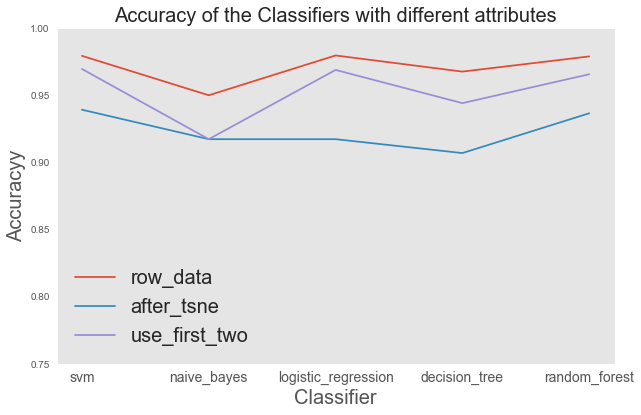

In [27]:
# drow a line
classifiers = ['svm', 'naive_bayes', 'logistic_regression', 'decision_tree', 'random_forest']
accuracy_data = [svm_model.score(X_test,Y_test),
                 nb_model.score(X_test,Y_test),
                 lr_model.score(X_test,Y_test),
                 dt_model.score(X_test,Y_test),
                 rf_model.score(X_test,Y_test)]
accuracy_data_tsne = [svm_model_tsne.score(X_test_tsne,Y_test_tsne),
                      nb_model_tsne.score(X_test_tsne,Y_test_tsne),
                      lr_model_tsne.score(X_test_tsne,Y_test_tsne),
                      dt_model_tsne.score(X_test_tsne,Y_test_tsne),
                      rf_model_tsne.score(X_test_tsne,Y_test_tsne)]
accuracy_data_two = [svm_model_two.score(X_test_two,Y_test_two),
                      nb_model_two.score(X_test_two,Y_test_two),
                      lr_model_two.score(X_test_two,Y_test_two),
                      dt_model_two.score(X_test_two,Y_test_two),
                      rf_model_two.score(X_test_two,Y_test_two)]

plt.style.use('ggplot')
plt_index = [1, 2, 3, 4, 5]
plt.figure(figsize=(10, 10/1.618))
plt.ylim(0.75, 1)
plt.title("Accuracy of the Classifiers with different attributes", fontsize=20)
plt.xlabel("Classifier", fontsize=20)
plt.xticks(plt_index, classifiers,fontsize=14)
plt.ylabel("Accuracyy", fontsize=20)
plt.plot(plt_index, accuracy_data,'-',label="row_data")
plt.plot(plt_index, accuracy_data_tsne,'-',label="after_tsne")
plt.plot(plt_index, accuracy_data_two,'-',label="use_first_two")
plt.legend(fontsize=20)
plt.grid()